In [1427]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder,StandardScaler

In [1380]:
df = pd.read_csv('Bengaluru_House_Data.csv')

In [1381]:
df.shape

(13320, 9)

In [1382]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [1383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [1384]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [1385]:
df.groupby('area_type')['area_type'].count()

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [1386]:
df['balcony'].unique()

array([ 1.,  3., nan,  2.,  0.])

In [1387]:
df = df.drop(['society', 'balcony'], axis=1)

df.head()

,area_type,availability,location,size,total_sqft,bath,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,51.00


In [1388]:
# df = df.dropna()
# print(df.shape)


In [1389]:
df['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], shape=(1306,), dtype=object)

In [1390]:
df['location'] = df['location'].fillna(df['location'].mode)

<Axes: ylabel='bath'>

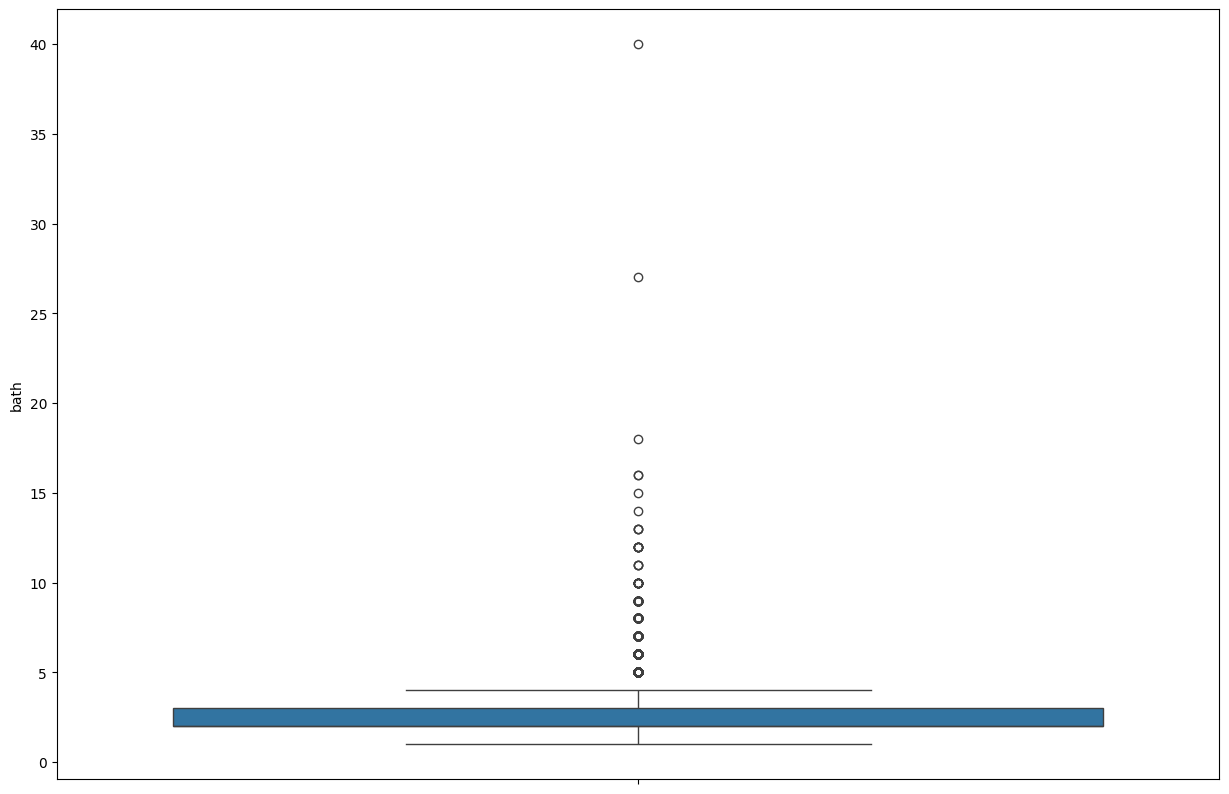

In [1391]:
sns.boxplot(df['bath'])

In [1392]:
# df['bath'] = df['bath'].fillna(df['bath'].median)

In [1393]:
def extract_bhk(x):
    try:
        return int(str(x).split(' ')[0])   # works for '2 BHK', '3 Bedroom', '1 RK'
    except:
        return None

# Extract BHK
df['bhk'] = df['size'].apply(extract_bhk)
df['bhk'] = df['bhk'].fillna(df['bhk'].median())



In [1394]:
# Cap bhk at 10
df['bhk'] = df['bhk'].apply(lambda x: 10 if x > 10 else x)

print(df['bhk'].value_counts().sort_index())


bhk
1.0      656
2.0     5528
3.0     4873
4.0     1417
5.0      356
6.0      221
7.0      100
8.0       89
9.0       54
10.0      26
Name: count, dtype: int64


In [1395]:
df = df.drop(columns=['size'])


In [1396]:
# 1. Fill missing bathrooms using bhk (if bath is NaN → set equal to bhk)
df['bath'] = df['bath'].fillna(df['bhk'])

# 2. Cap unrealistic bathrooms (if bath > bhk+2 → set = bhk+2)
df.loc[df['bath'] > df['bhk'] + 2, 'bath'] = df['bhk'] + 1


# 3. If bath is still missing (rare edge cases), fill with median
df['bath'] = df['bath'].fillna(df['bath'].median())




In [1397]:
df.isnull().sum()

area_type       0
availability    0
location        0
total_sqft      0
bath            0
price           0
bhk             0
dtype: int64

In [1398]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(2117,), dtype=object)

In [1399]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [1400]:
df['total_sqft'].apply(is_float)

0        True
1        True
2        True
3        True
4        True
         ... 
13315    True
13316    True
13317    True
13318    True
13319    True
Name: total_sqft, Length: 13320, dtype: bool

In [1401]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [1402]:
convert_sqft_to_num('20-20')

20.0

In [1403]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df['total_sqft']

0        1056.0
1        2600.0
2        1440.0
3        1521.0
4        1200.0
          ...  
13315    3453.0
13316    3600.0
13317    1141.0
13318    4689.0
13319     550.0
Name: total_sqft, Length: 13320, dtype: float64

In [1404]:
df['total_sqft']= df['total_sqft'].fillna(df['total_sqft'].median())

In [1405]:
df.loc[30]

area_type       Super built-up  Area
availability                  19-Dec
location                   Yelahanka
total_sqft                    2475.0
bath                             4.0
price                          186.0
bhk                              4.0
Name: 30, dtype: object

In [1406]:
# Dataset year (since created ~6 years ago)
REF_YEAR = 2019

# Function to extract built year
def get_built_year(avail):
    avail = str(avail).lower()   # make it string + lowercase

    # Case 1: Availability is a year (e.g., "2017", "2020")
    if avail.isdigit():
        year = int(avail)
        return year if year <= REF_YEAR else REF_YEAR

    # Case 2: Availability is in "YY-Mon" format (e.g., "18-Jan")
    if "-" in avail:
        year_prefix = int(avail.split("-")[0])   # "18" from "18-Jan"
        year = 2000 + year_prefix                # 18 -> 2018
        return year if year <= REF_YEAR else REF_YEAR

    # Case 3: Ready/Immediate/Available
    if "ready" in avail or "immediate" in avail or "available" in avail:
        return REF_YEAR - 3   # assume 3 years old

    # Default case (if nothing matches)
    return REF_YEAR

# Apply function to create built_year column
df["built_year"] = df["availability"].apply(get_built_year)

# Calculate property age
df["property_age"] = REF_YEAR - df["built_year"]

# Categorize into buckets
df["age_bucket"] = pd.cut(
    df["property_age"],
    bins=[-1, 2, 5, 10, 100],
    labels=["New", "Mid", "Old", "Very Old"]
)




In [1407]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

,area_type,availability,location,total_sqft,bath,price,bhk,built_year,property_age,age_bucket,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,1056.0,2.0,39.07,2.0,2019,0,New,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,2600.0,5.0,120.00,4.0,2016,3,Mid,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,1440.0,2.0,62.00,3.0,2016,3,Mid,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,1521.0,3.0,95.00,3.0,2016,3,Mid,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,1200.0,2.0,51.00,2.0,2016,3,Mid,4250.000000


In [1408]:
def remove_pps_outliners(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df = remove_pps_outliners(df)
df.shape

(10165, 11)

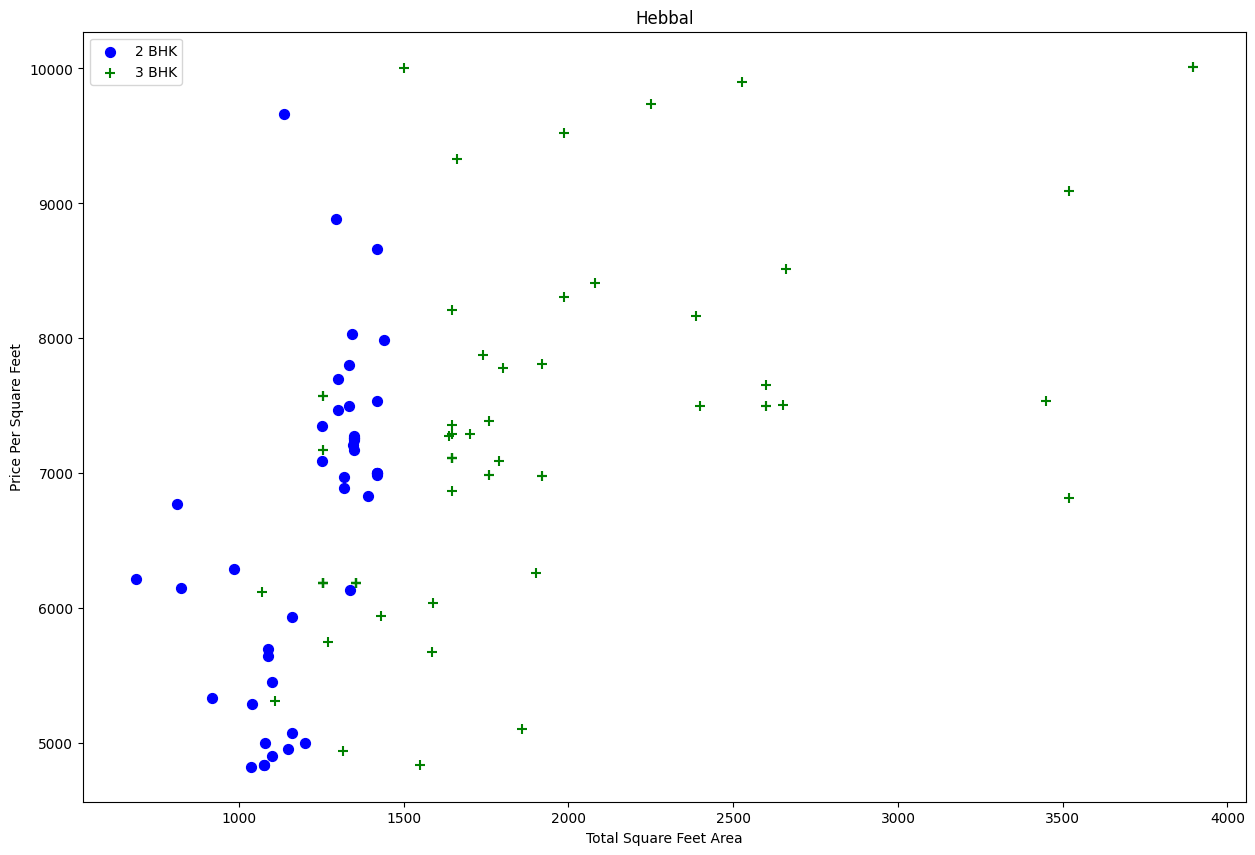

In [1409]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(bhk2.total_sqft, bhk2.price_per_sqft, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price_per_sqft, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df, "Hebbal")

In [1410]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df = remove_bhk_outliers(df)
df.shape

(8239, 11)

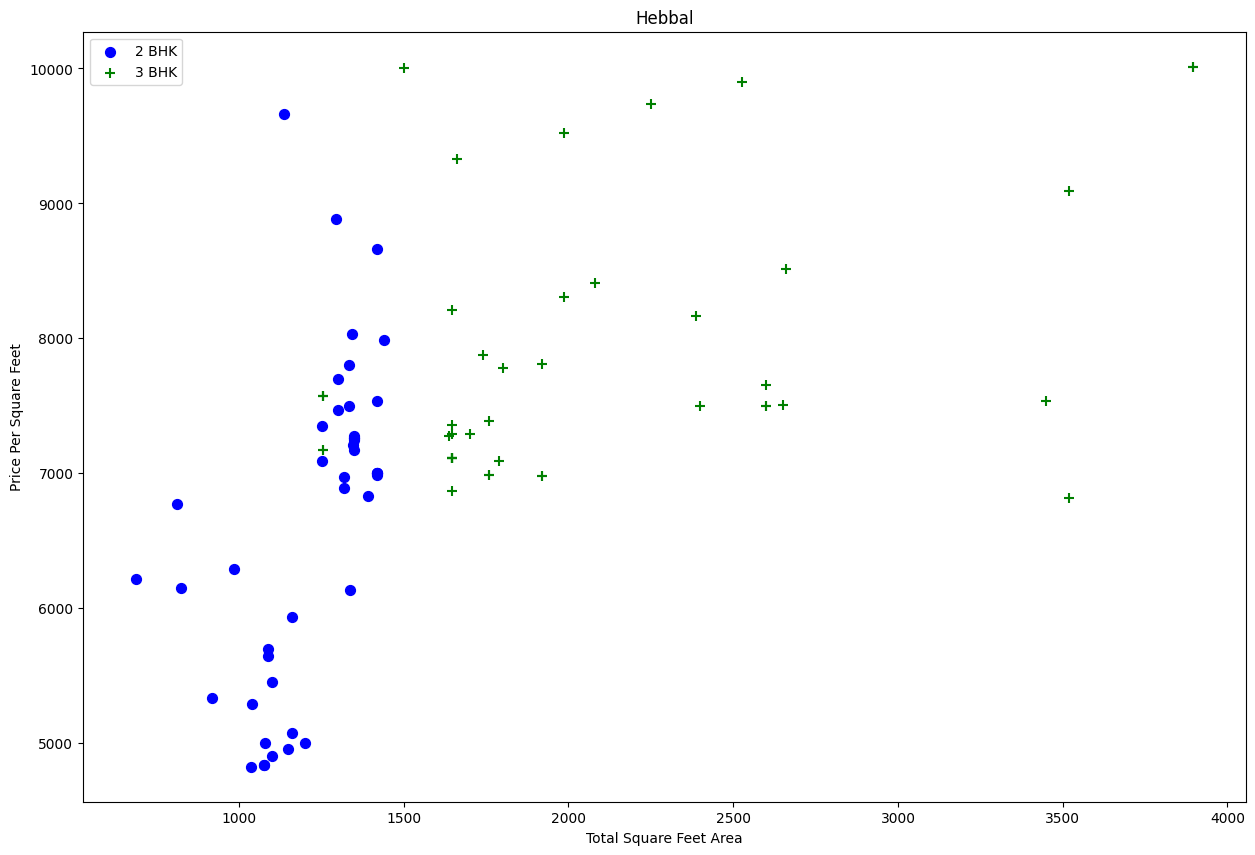

In [1411]:
plot_scatter_chart(df, "Hebbal")

In [1412]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8239 entries, 0 to 10164
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   area_type       8239 non-null   object  
 1   availability    8239 non-null   object  
 2   location        8239 non-null   object  
 3   total_sqft      8239 non-null   float64 
 4   bath            8239 non-null   float64 
 5   price           8239 non-null   float64 
 6   bhk             8239 non-null   float64 
 7   built_year      8239 non-null   int64   
 8   property_age    8239 non-null   int64   
 9   age_bucket      8239 non-null   category
 10  price_per_sqft  8239 non-null   float64 
dtypes: category(1), float64(5), int64(2), object(3)
memory usage: 716.3+ KB


In [1416]:
df = df.drop(columns=['price_per_sqft'])

In [1420]:
X = df.drop(columns=['price'])
y = df['price']

In [1421]:
Xtrain,Xtest,Ytrain,ytest = train_test_split(X,y,train_size=0.8,random_state=42)

In [1426]:
cat_col = df.select_dtypes(include='object').columns.tolist()
num_col = df.select_dtypes(include='number').columns.tolist()
num_col

['total_sqft', 'bath', 'price', 'bhk', 'built_year', 'property_age']

In [ ]:
std = 